In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import seaborn as sns

In [2]:
x_scale = 5
y_scale = 3

full_court_img = Image.open('../../data/wnba/ml-bg-court.png').resize((x_scale * 100, y_scale * 100), Image.ANTIALIAS)
full_court_img.size

(500, 300)

In [3]:
df_boxscores = pd.read_csv('../../data/wnba/wnba_boxscores.csv')
df_boxscores.head()

,side,team_name,player_name,id,nid,game_id,MIN,FG,3PT,FT,OREB,DREB,REB,AST,STL,BLK,TO,PF,+/-,PTS
0,away,Los Angeles Sparks,N. Ogwumike F,1068,nneka-ogwumike,401391651,37,7-10,2-3,3-3,2,5,7,2,3,0,3,2,+7,19
1,away,Los Angeles Sparks,A. Atwell F,4068885,amy-atwell,401391651,8,0-2,0-2,0-0,0,0,0,0,0,0,0,1,-7,0
2,away,Los Angeles Sparks,L. Cambage C,1017,liz-cambage,401391651,24,4-12,0-1,4-6,1,3,4,0,4,2,5,3,-3,12
3,away,Los Angeles Sparks,B. Sykes G,2988756,brittney-sykes,401391651,36,3-8,0-2,3-4,0,6,6,4,4,2,2,4,+3,9
4,away,Los Angeles Sparks,J. Canada G,3142250,jordin-canada,401391651,33,6-11,0-1,9-9,0,4,4,8,2,0,3,2,+3,21


In [4]:
df = pd.read_csv('../../data/wnba/wnba_shot_chart.csv')
df.head()

,game_id,description,location,made
0,401391651,Courtney Vandersloot misses 18-foot pullup jum...,"['bottom:calc(32% - 5px);', 'left:calc(78.72% ...",False
1,401391651,Dana Evans misses driving floating jump shot,"['bottom:calc(42% - 5px);', 'left:calc(87.23% ...",False
2,401391651,Azura Stevens makes 23-foot three point jumper...,"['bottom:calc(6% - 5px);', 'left:calc(91.49% -...",True
3,401391651,Candace Parker makes 14-foot two point shot (A...,"['bottom:calc(26% - 5px);', 'left:calc(88.3% -...",True
4,401391651,Candace Parker makes free throw 1 of 2,"['bottom:calc(429496780% - 5px);', 'left:calc(...",True


In [5]:
def who_shot(row):
    match = re.search(r'^([a-z]+[\s-]+)+(?=makes|misses)', row, flags=re.IGNORECASE)
    if match is not None:
        return match.group().strip()
        
    match = re.search(r'blocks\s+([a-z]+[\s-]+)+?(?=\'s)', row, flags=re.IGNORECASE)
    if match is None:
        return ''

    return re.sub(r'^blocks\s+', '', match.group()).strip()

def who_blocked(row):
    match = re.search(r'^([a-z]+[\s-]+)+(?=blocks)', row, flags=re.IGNORECASE)
    if match is None:
        return ''

    return match.group().strip()

def distance(row):
    match = re.search(r'(\d+)[\s-]+foot', row, flags=re.IGNORECASE)
    if match is None:
        return ''

    return match.group(1).strip()

def shot(row):
    match = re.search(r'(pullup|floating)\s+jump', row)
    if match is None:
        match = re.search(r'(layup)', row)

    if match is None:
        match = re.search(r'(free\s+throw)', row)

    if match is None:
        return 'set'

    return match.group(1).strip()

def assist(row):
    match = re.search(r'\(((?:[a-z]+[\s-])+)(?=assists)', row, flags=re.IGNORECASE)
    if match is None:
        return ''

    return match.group(1).strip()

def is_3pt(row):
    shot_distance = row['shot_distance']
    if len(shot_distance) > 0:
        return int(shot_distance) >= 22
    
    return len(re.findall(r'three\s+point', row['description'])) > 0

df['shot_by'] = df.description.map(who_shot)
df['shot_distance'] = df.description.map(distance)
df['blocked_by'] = df.description.map(who_blocked)
df['shot_type'] = df.description.map(shot)
df['assist_by'] = df.description.map(assist)

df['is_3pt'] = df.apply(is_3pt, axis=1)

In [6]:
def parse(loc):
  locations = list(map(float, re.findall(r'calc\(([\d.]+)%', ' '.join(loc))))
  if len(locations) != 2:
    return [-1, -1]

  return locations

def is_valid(loc):
  return not any(list(map(lambda a: a > 100 or a < 0, loc)))

df.location = df.location.map(eval).map(parse)
df['is_valid'] = df.location.map(is_valid)

df.head(n=10)

,game_id,description,location,made,shot_by,shot_distance,blocked_by,shot_type,assist_by,is_3pt,is_valid
0,401391651,Courtney Vandersloot misses 18-foot pullup jum...,"[32.0, 78.72]",False,Courtney Vandersloot,18,,pullup,,False,True
1,401391651,Dana Evans misses driving floating jump shot,"[42.0, 87.23]",False,Dana Evans,,,floating,,False,True
2,401391651,Azura Stevens makes 23-foot three point jumper...,"[6.0, 91.49]",True,Azura Stevens,23,,set,Candace Parker,True,True
3,401391651,Candace Parker makes 14-foot two point shot (A...,"[26.0, 88.3]",True,Candace Parker,14,,set,Azura Stevens,False,True
4,401391651,Candace Parker makes free throw 1 of 2,"[429496780.0, 228455803.19]",True,Candace Parker,,,free throw,,False,False
5,401391651,Candace Parker makes free throw 2 of 2,"[429496780.0, 228455803.19]",True,Candace Parker,,,free throw,,False,False
6,401391651,Candace Parker makes 25-foot three point jumpe...,"[24.0, 73.4]",True,Candace Parker,25,,set,Courtney Vandersloot,True,True
7,401391651,Azura Stevens makes 2-foot layup (Candace Park...,"[48.0, 94.68]",True,Azura Stevens,2,,layup,Candace Parker,False,True
8,401391651,Azura Stevens misses two point shot,"[42.0, 95.74]",False,Azura Stevens,,,set,,False,True
9,401391651,Brittney Sykes blocks Kaela Davis 's 2-foot dr...,"[54.0, 93.62]",False,Kaela Davis,2,Brittney Sykes,layup,,False,True


In [7]:
## only use the valid shot locations moving forward
df_valid = df[df.is_valid].copy()

In [8]:
def side(loc):
  return 'right' if loc[1] >= 50  else 'left'

df_valid['side_of_court'] = df_valid.location.map(lambda loc: 'right' if loc[1] >= 50  else 'left')

def flip(row):

  location = row['location']

  if row['side_of_court'] == 'right':
    x = location[1]
    y = location[0]  

    return [round(100-y, 1), round(100-x, 1)]

  return location

df_valid['single_location'] = df_valid.apply(flip, axis=1)
df_valid['side_of_the_half_court'] = df_valid.single_location.map(lambda loc: 'right' if loc[0] < 50 else 'left') ## doesnt make sense yet...

df_valid.head(n=5)

,game_id,description,location,made,shot_by,shot_distance,blocked_by,shot_type,assist_by,is_3pt,is_valid,side_of_court,single_location,side_of_the_half_court
0,401391651,Courtney Vandersloot misses 18-foot pullup jum...,"[32.0, 78.72]",False,Courtney Vandersloot,18,,pullup,,False,True,right,"[68.0, 21.3]",left
1,401391651,Dana Evans misses driving floating jump shot,"[42.0, 87.23]",False,Dana Evans,,,floating,,False,True,right,"[58.0, 12.8]",left
2,401391651,Azura Stevens makes 23-foot three point jumper...,"[6.0, 91.49]",True,Azura Stevens,23,,set,Candace Parker,True,True,right,"[94.0, 8.5]",left
3,401391651,Candace Parker makes 14-foot two point shot (A...,"[26.0, 88.3]",True,Candace Parker,14,,set,Azura Stevens,False,True,right,"[74.0, 11.7]",left
6,401391651,Candace Parker makes 25-foot three point jumpe...,"[24.0, 73.4]",True,Candace Parker,25,,set,Courtney Vandersloot,True,True,right,"[76.0, 26.6]",left


In [9]:
player = 'Kelsey Plum' ## 'Sylvia Fowles'
df_player = df_valid[df_valid.shot_by == player]

df_player.head()

,game_id,description,location,made,shot_by,shot_distance,blocked_by,shot_type,assist_by,is_3pt,is_valid,side_of_court,single_location,side_of_the_half_court
1119,401391696,Kelsey Plum makes driving layup,"[48.0, 5.32]",True,Kelsey Plum,,,layup,,False,True,left,"[48.0, 5.32]",right
1130,401391696,Kelsey Plum makes driving layup,"[48.0, 4.26]",True,Kelsey Plum,,,layup,,False,True,left,"[48.0, 4.26]",right
1132,401391696,Kelsey Plum makes 25-foot three pointer (Jacki...,"[40.0, 29.79]",True,Kelsey Plum,25,,set,Jackie Young,True,True,left,"[40.0, 29.79]",right
1134,401391696,Kelsey Plum makes 24-foot step back jumpshot (...,"[20.0, 24.47]",True,Kelsey Plum,24,,set,Theresa Plaisance,True,True,left,"[20.0, 24.47]",right
1135,401391696,Kelsey Plum misses 24-foot step back jumpshot,"[70.0, 27.66]",False,Kelsey Plum,24,,set,,True,True,left,"[70.0, 27.66]",left


In [10]:
def get_makes_and_misses_full_court(df):
    def get_coordinates(df):
        x = df.location.map(lambda a: a[1])
        y = df.location.map(lambda a: a[0])

        return x, y

    df_sub = df[df.blocked_by.map(lambda bb: len(bb) == 0)]

    x_make, y_make = get_coordinates(df_sub[df_sub.made])
    x_missed, y_missed = get_coordinates(df_sub[~df_sub.made])

    return x_make, y_make, x_missed, y_missed

Kelsey Plum - shot chart


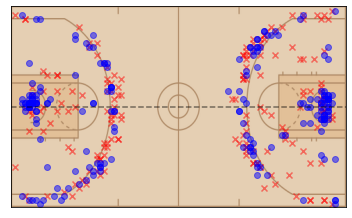

In [11]:
print(f'{player} - shot chart')

fig, ax = plt.subplots()

ax.imshow(full_court_img)

plt.xticks([])
plt.yticks([])

x_make, y_make, x_missed, y_missed = get_makes_and_misses_full_court(df_player)

plt.scatter(x_missed * x_scale, y_missed * y_scale, marker='x', c='red', alpha=.5)
plt.scatter(x_make * x_scale, y_make * y_scale, marker='o', c='blue', alpha=.5)

plt.axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')

plt.show()

In [12]:
def get_makes_and_misses_half_court(df):
    def get_coordinates(df):
        x = df.single_location.map(lambda a: a[1])
        y = df.single_location.map(lambda a: a[0])

        return x, y

    df_sub = df[df.blocked_by.map(lambda bb: len(bb) == 0)]

    x_make, y_make = get_coordinates(df_sub[df_sub.made])
    x_missed, y_missed = get_coordinates(df_sub[~df_sub.made])

    return x_make, y_make, x_missed, y_missed

Kelsey Plum - shot chart


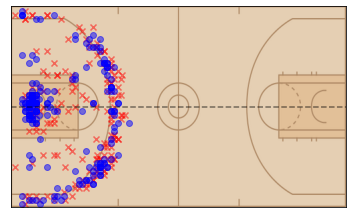

In [13]:
print(f'{player} - shot chart')

fig, ax = plt.subplots()

ax.imshow(full_court_img)

plt.xticks([])
plt.yticks([])

x_make, y_make, x_missed, y_missed = get_makes_and_misses_half_court(df_player)

plt.scatter(x_missed * x_scale, y_missed * y_scale, marker='x', c='red', alpha=.5)
plt.scatter(x_make * x_scale, y_make * y_scale, marker='o', c='blue', alpha=.5)

plt.axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')

plt.show()

## How well did we pick up 3pt?

Kelsey Plum - shot chart


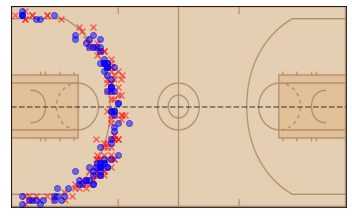

In [14]:
print(f'{player} - shot chart')

fig, ax = plt.subplots()

ax.imshow(full_court_img)

plt.xticks([])
plt.yticks([])

x_make, y_make, x_missed, y_missed = get_makes_and_misses_half_court(df_player[df_player.is_3pt])

plt.scatter(x_missed * x_scale, y_missed * y_scale, marker='x', c='red', alpha=.5)
plt.scatter(x_make * x_scale, y_make * y_scale, marker='o', c='blue', alpha=.5)

plt.axhline(50 * y_scale, c='k', alpha=.5, linestyle= '--')

plt.show()

In [15]:
df_player[df_player.is_3pt].groupby(['made', 'side_of_the_half_court']).count()[['game_id']]

game_id
made  side_of_the_half_court         
False left                         75
      right                        50
True  left                         56
      right                        40

In [16]:
df_agg_makes = df[np.logical_and(np.logical_and(df.shot_by == player, df.is_3pt), df.made)].groupby(['game_id']).count()[['made']]
df_agg_misses = df[np.logical_and(np.logical_and(df.shot_by == player, df.is_3pt), ~df.made)].groupby(['game_id']).count()[['made']]
df_agg_misses.columns = ['misses']

df_totals = df_agg_makes.join(df_agg_misses)
def format_3pt(row):
    made = row['made']
    miss = row['misses']
    total = made + miss

    return f'{made}-{total}'

df_totals['3PT'] = df_totals.apply(format_3pt, axis=1)

In [17]:
pd.merge(
    df_boxscores.loc[df_boxscores.id == 3065570, ['game_id', '3PT']],
    df_totals,
    how="left",
    on='game_id'
)

,game_id,3PT_x,made,misses,3PT_y
0,401391696,2-4,2,2,2-4
1,401391747,3-8,3,5,3-8
2,401391652,5-9,5,4,5-9
3,401391657,2-5,2,4,2-6
4,401391659,3-7,3,4,3-7
5,401391665,3-4,3,1,3-4
6,401391675,4-8,4,4,4-8
7,401391678,1-8,1,7,1-8
8,401391683,3-6,3,3,3-6
9,401391687,5-8,5,3,5-8


### Takeaways:
  - 22-foot not exactly == 3pt

  - when no distance maybe look at location... create a simple ploy model to help with those?
